Our objective is to make a 6 weeks sales prediction for 1115 Rossmann stores. We will do data cleaning and EDA. In a first step, we will apply univariate time series and fit a model to each store and we will see how far we come with only the sales data. After that, we will use feature engineering to apply advanced supervised learning algorithms.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


##### Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

In [2]:
# Load data
train = pd.read_csv("/Users/manueloers/Downloads/rossmann-store-sales/train.csv", low_memory=False, index_col="Date", parse_dates=True)
store = pd.read_csv("/Users/manueloers/Downloads/rossmann-store-sales/store.csv")

# Shape of each dataset
print("The train dataset has the following shape:", train.shape)
print("The store dataset has the following shape:", store.shape)

# Lets look at the first 5 row of the train dataset
print("\nThe first 5 rows of the train dataset:")
train.head()

The train dataset has the following shape: (1017209, 8)
The store dataset has the following shape: (1115, 10)

The first 5 rows of the train dataset:


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [3]:
print(train.index)
print("\nThe train dataset consists of daily sales data for 1115 Rossmann stores from 01/01/2013 to 07/31/2015\n")

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

The train dataset consists of daily sales data for 1115 Rossmann stores from 01/01/2013 to 07/31/2015



In [400]:
# Number of unique Stores in the train dataset
print(train["Store"].nunique())

print(f"In the train dataset we are dealing with {train.shape[0]} entries and {train.shape[1]} features.")

1115
In the train dataset we are dealing with 1017209 entries and 11 features.


### Handling Missing Values

In [5]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [403]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
 8   Year           1017209 non-null  int64 
 9   Month          1017209 non-null  int64 
 10  Day            1017209 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 93.1+ MB


### Checking for Correlations

The main approach in this notebook will be to use univariate time series models and for that reason we are for now only interested features that correlate the most with the target variable which are "Open" and "Promo". The "Open" varibale will be used as an indicator for holidays and the "Promo" variable as an additional exogeneous variable which the SARIMA models allows us to use as an input. Let's check if the entries for "Sales" and "Open", "Promo" dont have strange entries.

<AxesSubplot: xlabel='Date'>

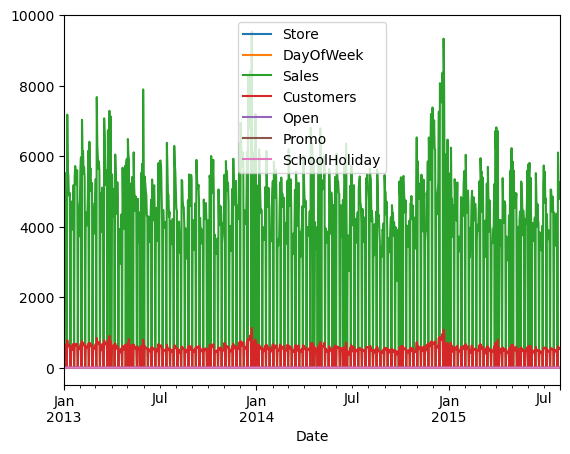

In [6]:
train[(train.Store == 1)].plot()

In [7]:
corr_matrix = train.corr()

In [9]:
corr_matrix

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000


In [12]:
corr_matrix["Sales"].sort_values(ascending=False)

Sales            1.000000
Customers        0.894711
Open             0.678472
Promo            0.452345
SchoolHoliday    0.085124
Store            0.005126
DayOfWeek       -0.462125
Name: Sales, dtype: float64

We will not use "Customer" because in real out-of-sample forecasts we would not know the true number of customers.

In [13]:
print(train["Sales"].value_counts())
print(train["Open"].value_counts())
print(train["Promo"].value_counts())
print(train["DayOfWeek"].value_counts())

0        172871
5674        215
5558        197
5483        196
6214        195
          ...  
23806         1
24183         1
20651         1
25083         1
23303         1
Name: Sales, Length: 21734, dtype: int64
1    844392
0    172817
Name: Open, dtype: int64
0    629129
1    388080
Name: Promo, dtype: int64
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: DayOfWeek, dtype: int64


Looks good!

In [22]:
df_s1 = train[(train.Store == 1)]

In [23]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis. According to the Dickey-Fuller-Test we have a stationary series.")
    else:
        print("There is weak evidence against the null hypothesis which indicates that the time series has a unit root and is non-stationary ")



adf_test(df_s1['Sales'])

ADF Statistics: -4.374783612581179
p- value: 0.00032886553525140143
There is strong evidence against the null hypothesis. According to the Dickey-Fuller-Test we have a stationary series.


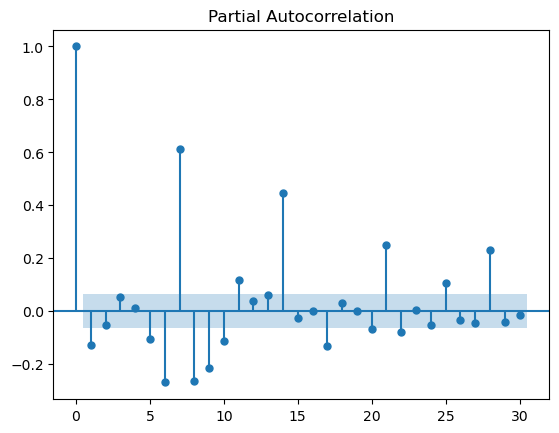

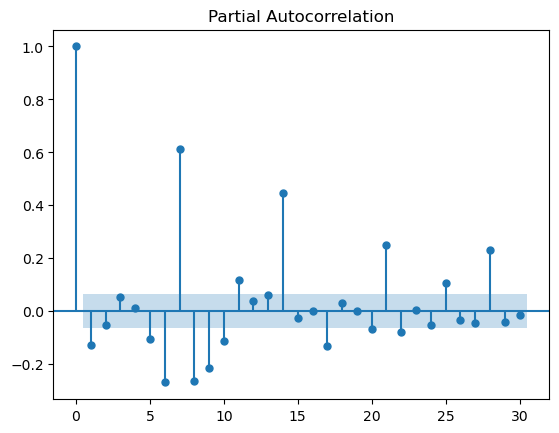

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_pacf(df_s1["Sales"])


We see a significant lag at every 7th lag indicating that the sales target variable is strongly seasonal.

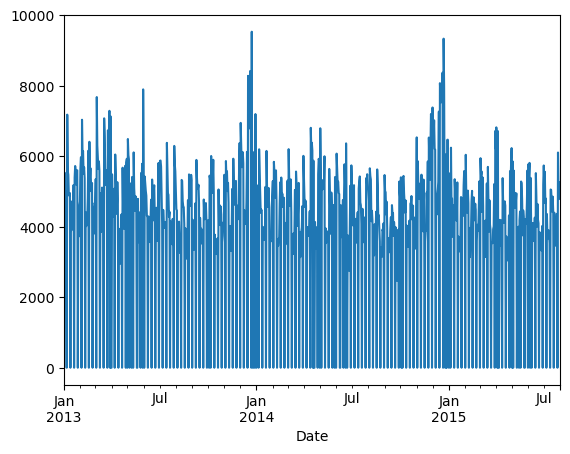

In [28]:
df_s1["Sales"].plot()
test_s1 = df_s1.iloc[:49]
train_s1 = df_s1.iloc[49:]

### Persistence Model

      t-1   t+1
0     NaN  5263
1  5263.0  5020
2  5020.0  4782
3  4782.0  5011
4  5011.0  6102
Test RMSE: 3010.634


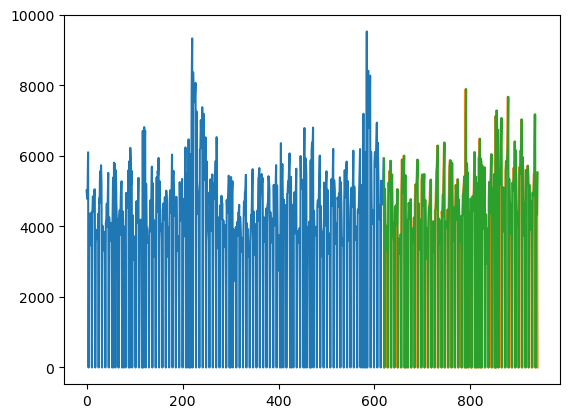

In [32]:
# Data
series = df_s1["Sales"]

# Create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))


# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train_per, test_per = X[1:train_size], X[train_size:]
train_X_per, train_y_per = train_per[:,0], train_per[:,1]
test_X_per, test_y_per = test_per[:,0], test_per[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X_per:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = np.sqrt(mean_squared_error(test_y_per, predictions))
print('Test RMSE: %.3f' % test_score)

# plot predictions and expected results
plt.plot(train_y_per)
plt.plot([None for i in train_y_per] + [x for x in test_y_per])
plt.plot([None for i in train_y_per] + [x for x in predictions])
plt.show()

### Model Training

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45470D+00    |proj g|=  5.94533D-01

At iterate    5    f=  8.12824D+00    |proj g|=  1.42514D-02

At iterate   10    f=  8.11631D+00    |proj g|=  4.06612D-03

At iterate   15    f=  8.11578D+00    |proj g|=  1.42356D-03

At iterate   20    f=  8.10713D+00    |proj g|=  1.46618D-01

At iterate   25    f=  7.85883D+00    |proj g|=  3.85285D-02

At iterate   30    f=  7.83437D+00    |proj g|=  1.46997D-01

At iterate   35    f=  7.82311D+00    |proj g|=  2.06859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

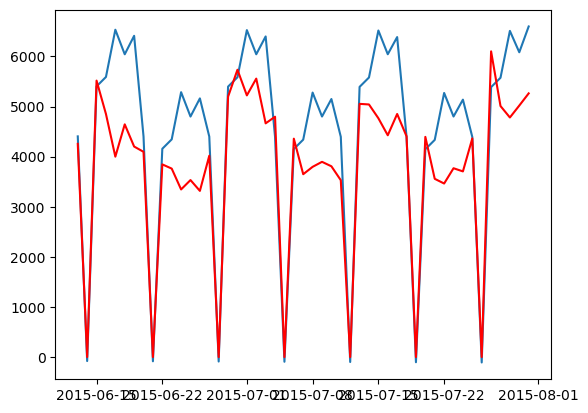

In [33]:
from codecs import ignore_errors
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA=SARIMAX(train_s1["Sales"],order=(0,0,2),seasonal_order=(0,2,2,7), exog=train_s1[["Open", "Promo"]], ignore_errors=True)
model_SARIMA_fit=model_SARIMA.fit(ignore_errors=True)

print(model_SARIMA_fit.summary())
pred = pred_Sarima=model_SARIMA_fit.forecast(steps=49, exog=test_s1[["Open", "Promo"]])
pred.index = test_s1.index
pred
plt.plot(pred)
plt.plot(test_s1["Sales"], color="Red")

Amazing how our model predict 6 weeks ahead by only using the recursive strategy.

<AxesSubplot: xlabel='Date'>

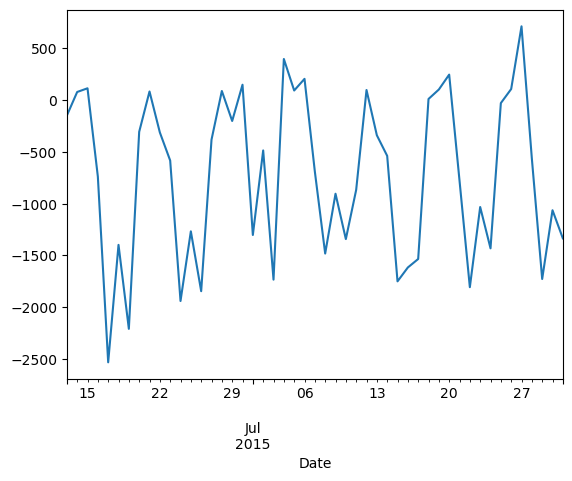

In [34]:
resid = test_s1["Sales"] - pred
resid.plot()

We can see that there still potential. The model has not caught the entire seasonality.

<AxesSubplot: ylabel='Density'>

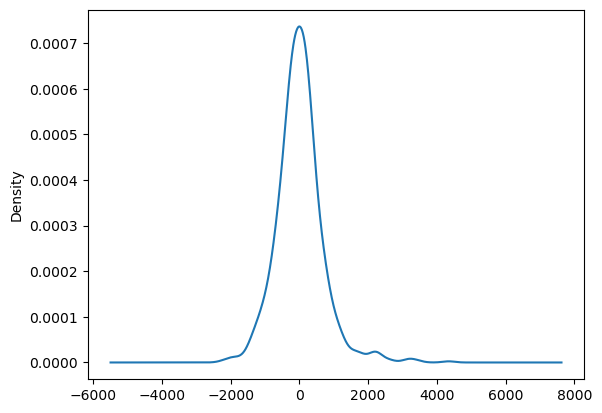

In [35]:
model_SARIMA_fit.resid.plot(kind="kde")

The RMSE is not satisfying but a lot better than the persistence model's RMSE. 

In [40]:
df_s1.index

DatetimeIndex(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
               '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
               '2015-07-23', '2015-07-22',
               ...
               '2013-01-10', '2013-01-09', '2013-01-08', '2013-01-07',
               '2013-01-06', '2013-01-05', '2013-01-04', '2013-01-03',
               '2013-01-02', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=942, freq=None)

In [42]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [46]:
df_s1 = create_features(df_s1)

Text(0.5, 1.0, 'MW by Hour')

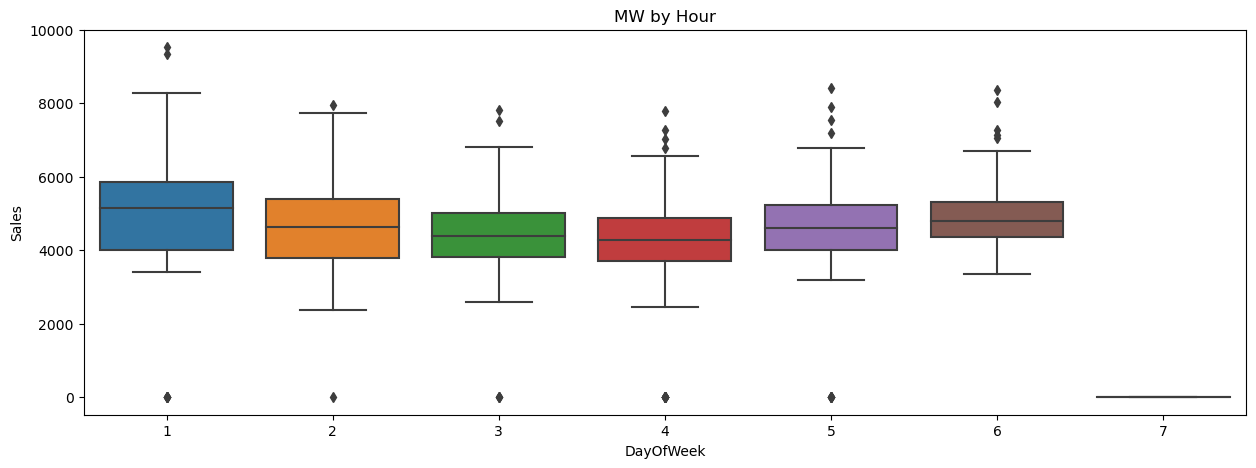

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df_s1, x='DayOfWeek', y='Sales')
ax.set_title('MW by Hour')


In [47]:
df_s1.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [63]:
FEATURES_num = ['Store', 'DayOfWeek', 'Open', 'Promo',
            'SchoolHoliday', 'quarter', 'month', 'year',
            'dayofyear']
TARGET = 'Sales'
test_s1 = df_s1.iloc[:49]
train_s1 = df_s1.iloc[49:]


In [66]:
X_train = train_s1[FEATURES_num]
y_train = train_s1[TARGET]

X_test = test_s1[FEATURES_num]
y_test = test_s1[TARGET]


In [67]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
        )


[21:13:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4401.92282	validation_1-rmse:4098.41606
[100]	validation_0-rmse:1737.93095	validation_1-rmse:1394.30746
[200]	validation_0-rmse:864.05232	validation_1-rmse:540.66463
[300]	validation_0-rmse:616.65777	validation_1-rmse:382.75185
[400]	validation_0-rmse:536.32815	validation_1-rmse:375.73365
[416]	validation_0-rmse:528.69440	validation_1-rmse:376.48263


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [68]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_, columns=['importance'])


<AxesSubplot: title={'center': 'Feature Importance'}>

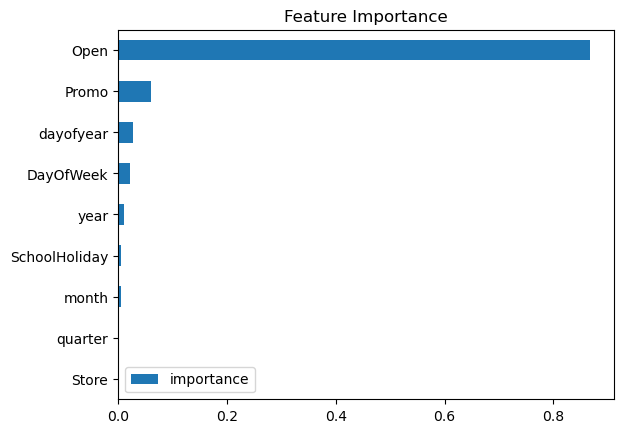

In [69]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')


In [71]:
test_s1['prediction'] = reg.predict(X_test)


In [73]:
df_s1 = df_s1.merge(test_s1[["prediction"]], how="left",
              left_index=True, right_index=True)


Text(0.5, 1.0, 'Raw Data and Predictions')

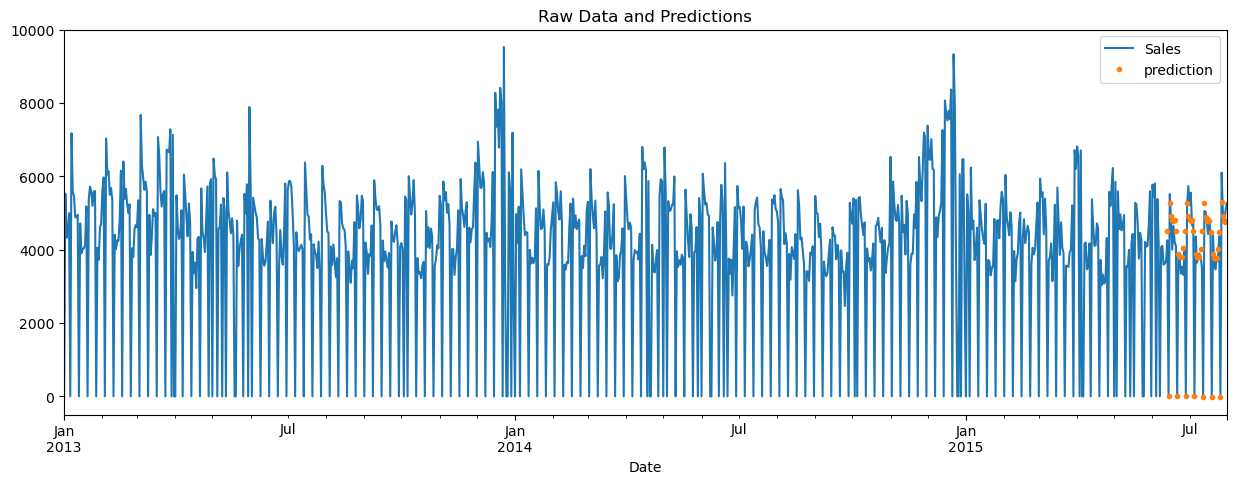

In [77]:
ax = df_s1[["Sales"]].plot(figsize=(15,5))
df_s1["prediction"].plot(ax=ax, style=".")
ax.legend()
ax.set_title("Raw Data and Predictions")

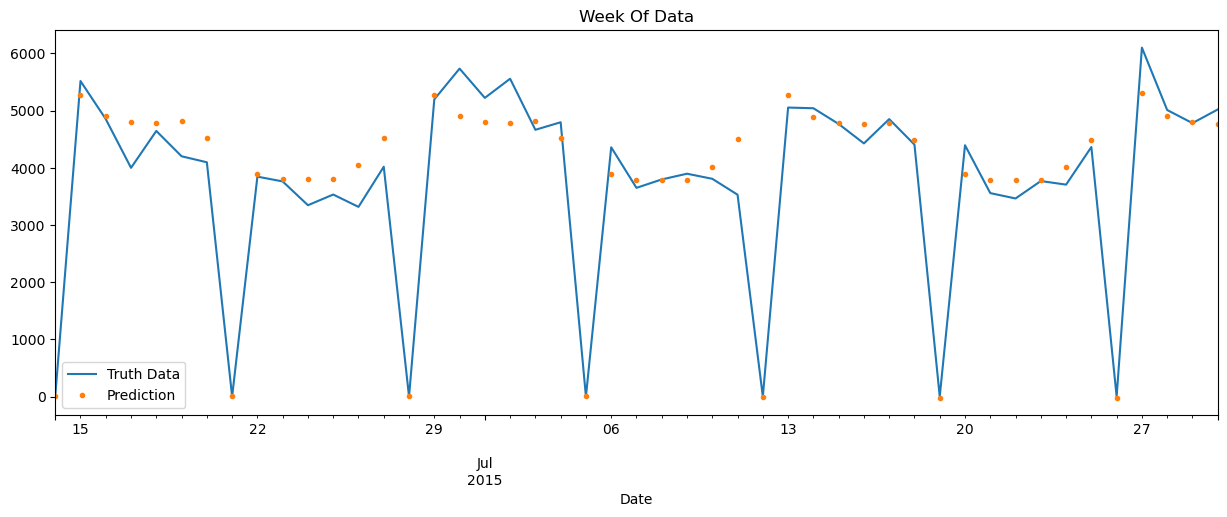

In [85]:
ax = df_s1.loc[(df_s1.index > '2015-06-13') & (df_s1.index < '2015-07-31')]['Sales'].plot(figsize=(15, 5), title='Week Of Data')
df_s1.loc[(df_s1.index > '2015-06-13') & (df_s1.index < '2015-07-31')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


In [82]:
df_s1["prediction"].iloc[:49]

Date
2015-07-31    4784.807617
2015-07-30    4760.013672
2015-07-29    4795.336426
2015-07-28    4908.724121
2015-07-27    5303.782715
2015-07-26     -18.483509
2015-07-25    4491.815918
2015-07-24    4013.567383
2015-07-23    3779.411377
2015-07-22    3779.411377
2015-07-21    3779.411377
2015-07-20    3891.027344
2015-07-19     -18.483509
2015-07-18    4491.815918
2015-07-17    4784.807617
2015-07-16    4769.057617
2015-07-15    4780.002441
2015-07-14    4893.390137
2015-07-13    5282.147949
2015-07-12     -12.182570
2015-07-11    4500.859863
2015-07-10    4022.611572
2015-07-09    3788.455566
2015-07-08    3788.455566
2015-07-07    3788.455566
2015-07-06    3893.770508
2015-07-05       9.165053
2015-07-04    4522.206543
2015-07-03    4815.198242
2015-07-02    4790.404297
2015-07-01    4801.349121
2015-06-30    4914.736816
2015-06-29    5282.147949
2015-06-28       9.165053
2015-06-27    4522.206543
2015-06-26    4043.958984
2015-06-25    3809.802979
2015-06-24    3809.802979
2015-06